# FMAT3888 Assignment 1
## Group 1, YOUR SID
 --- 

In [3]:
# Imports
import numpy as np
import scipy
import scipy.stats as sc
import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import yfinance as yf
from scipy.stats import norm
import sobol_seq


print(np.__version__)
print(sns.__version__)
print(scipy.__version__)
print(matplotlib.__version__)
print(sns.__version__)
print(pd.__version__)

1.26.4
0.13.2
1.13.0
3.9.0
0.13.2
2.2.2


## Add your own model here


### Terminal Value Monte Carlo

To simulate the price of an European Call Option, we simulate the terminal value of the stock and calculate the option price.  

We use the basic Black Scholes Equation: 
$$ dS_t = rS_tdt + \sigma S_tdW_t $$  

And we find the closed form as: 
$$ S_{T} = S_{0} e ^{(r - \frac{1}{2} \sigma^2)T + \sigma \sqrt{T}X} $$  

We test how the price of the option converges as we range the number of paths we generate using each model with the following initial conditions: 
$$ S0 = 100 $$
$$ r = 0.07 $$
$$ \sigma = 0.25 $$
$$ T = 1 $$ 
$$ N = 50000 $$
$$ K = 110 $$

In [4]:
S0 = 100
r = 0.07
sigma = 0.25
T = 1
K = 110
N = 20000
ns = np.arange(1, N+1, 100)

#### Standard Method

In [5]:
out_normal = np.zeros(len(ns))
sd_samples = np.zeros(len(ns))
sample_zeros = np.zeros(len(ns))
for i in range(len(ns)):
    sample = np.random.normal(size = ns[i])
    price = - K + S0 * np.e ** ((r - 1/2 * sigma ** 2) * T + sigma * np.sqrt(T) * sample)
    price[price < 0] = 0
    sd_samples[i] = np.sqrt(np.var(price)/ns[i])
    sample_zeros[i] = np.sum(price == 0)/ns[i]
    out_normal[i] = np.mean(price) * np.e ** (-r * T)

In [6]:
def fit_func(x, a, b):
    return a * x ** b

In [7]:
popt, _ = scipy.optimize.curve_fit(fit_func, np.log(ns[1:]), np.log(sd_samples[1:]))

In [8]:
coefs = np.polyfit(np.log(ns[1:]), np.log(sd_samples[1:]), 1)
slope, intercept = coefs

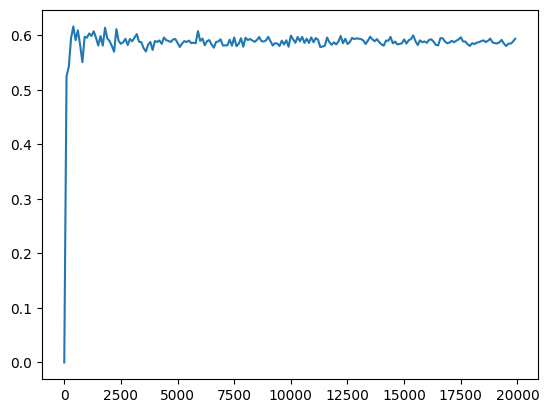

In [9]:
plt.plot(ns, sample_zeros)

In [10]:
np.var(out_normal)

12.271345019003727

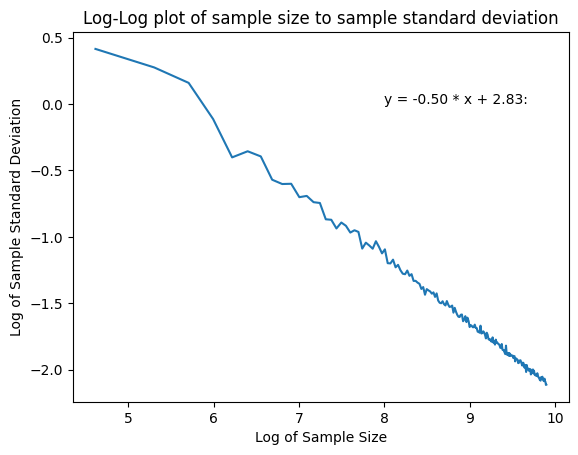

In [11]:
plt.plot(np.log(ns[1:]), np.log(sd_samples[1:]))
plt.title("Log-Log plot of sample size to sample standard deviation")
plt.xlabel("Log of Sample Size")
plt.ylabel("Log of Sample Standard Deviation")
plt.text(8, 0, f"y = {slope:.2f} * x + {intercept:.2f}:")
plt.savefig("Convergence of Simple MC.png")

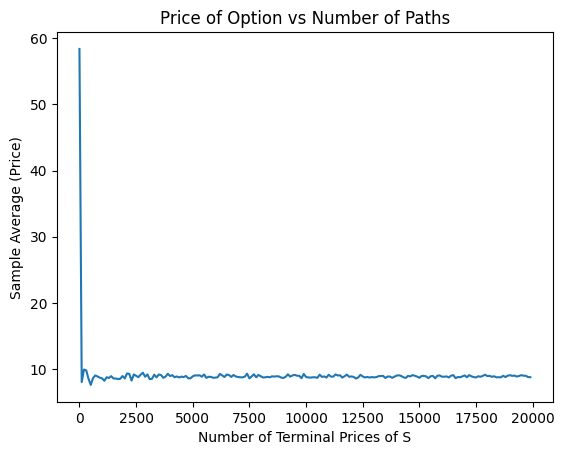

In [12]:
plt.plot(ns, out_normal)
plt.xlabel("Number of Terminal Prices of S")
plt.ylabel("Sample Average (Price)")
plt.title("Price of Option vs Number of Paths")
plt.savefig("SimpleMC.png")

Text(0.5, 1.0, 'Price of Option vs Number of Paths')

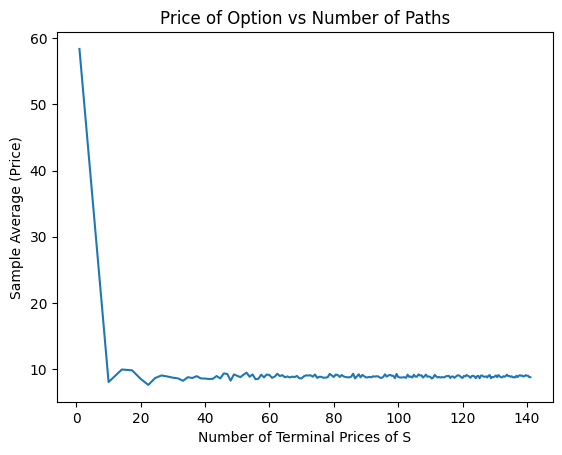

In [13]:
plt.plot(np.sqrt(ns), out_normal)
plt.xlabel("Number of Terminal Prices of S")
plt.ylabel("Sample Average (Price)")
plt.title("Price of Option vs Number of Paths")

In [14]:
out_normal[-1]

8.753368894812375

#### Antithetic

In [15]:
ns = np.arange(2, N+1, 100)
out_anti = np.zeros(len(ns))
sd_samples_anti = np.zeros(len(ns))
sample_zeros_anti = np.zeros(len(ns))
for i in range(len(ns)):
    sample = np.random.normal(size = int(ns[i]/2))
    sample_inv = -sample
    sample_f = np.concatenate((sample, sample_inv))
    price = - K + S0 * np.e ** ((r - 1/2 * sigma ** 2) * T + sigma * np.sqrt(T) * sample_f)
    price[price < 0] = 0
    sd_samples_anti[i] = np.sqrt(np.var(price)/ns[i])
    sample_zeros_anti[i] = np.sum(price == 0)/ns[i]
    out_anti[i] = np.mean(price) * np.e ** (-r * T)

In [16]:
coefs_anti = np.polyfit(np.log(ns[1:]), np.log(sd_samples_anti[1:]), 1)
slope_anti, intercept_anti = coefs_anti

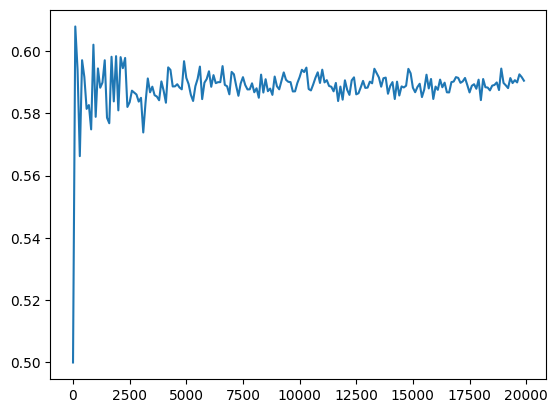

In [17]:
plt.plot(ns, sample_zeros_anti)


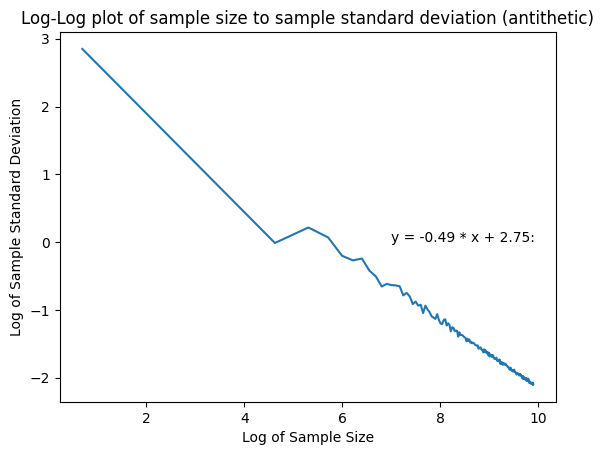

In [18]:
plt.plot(np.log(ns), np.log(sd_samples_anti))
plt.title("Log-Log plot of sample size to sample standard deviation (antithetic)")
plt.xlabel("Log of Sample Size")
plt.ylabel("Log of Sample Standard Deviation")
plt.text(7, 0, f"y = {slope_anti:.2f} * x + {intercept_anti:.2f}:")
plt.savefig("convergenceAnti.png")

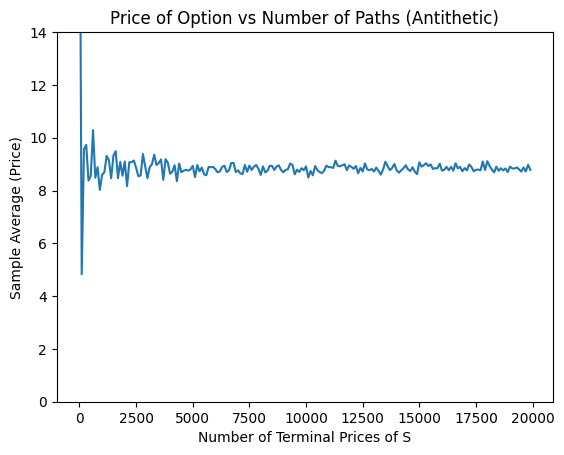

In [19]:
plt.plot(ns, out_anti)
#plt.plot(ns, out_normal)
plt.xlabel("Number of Terminal Prices of S")
plt.ylabel("Sample Average (Price)")
plt.title("Price of Option vs Number of Paths (Antithetic)")
plt.ylim([0, 14])
plt.savefig("AntiStock.png")

In [20]:
np.var(out_anti)

1.1041587397886747

#### Importance Sampling

In [21]:
def P(x):
    return (1/np.sqrt(2 * np.pi)) * np.exp(-0.5 * x**2)

#N(2, 4)
def Q(x):
    return (1/np.sqrt(2 * np.pi * 2)) * np.exp(-0.5 * (x-2)**2 /2)

def f(x, K):
    res =  S0 * np.e ** ((r - 1/2 * sigma ** 2) * T + sigma * np.sqrt(T) * x) - K
    res[res < 0] = 0
    return res

In [22]:
out_imp = np.zeros(len(ns))
sd_sample_imp = np.zeros(len(ns))
sample_zeros_imp = np.zeros(len(ns))
for i in range(len(ns)):
    sample = np.random.normal(loc = 2, scale = np.sqrt(4), size = ns[i]) 
    weights = P(sample)/Q(sample)
    estimate = np.sum(f(sample, K) * weights) / (ns[i])
    out_imp[i] = estimate * np.e ** (-r * T) + 2
    sd_sample_imp[i] = np.sqrt(np.var(f(sample, K) * weights))/ns[i]
    sample_zeros_imp[i] = np.sum(f(sample, K) * weights == 0) / ns[i]

In [23]:
coefs_imp = np.polyfit(np.log(ns[1:]), np.log(sd_sample_imp[1:]), 1)
slope_imp, intercept_imp = coefs_imp

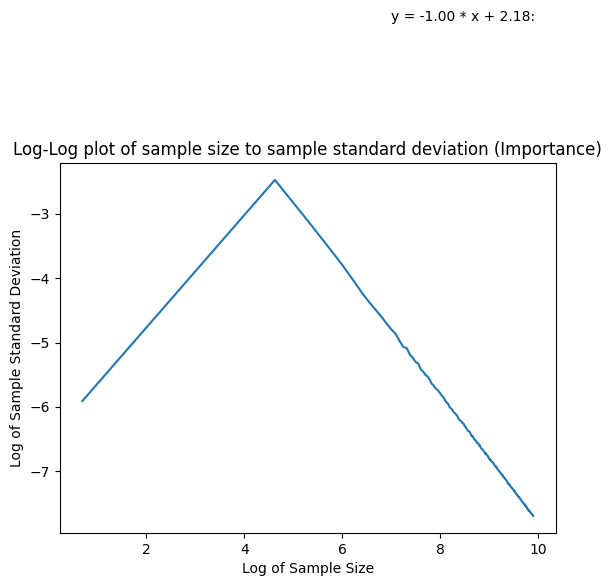

In [24]:
plt.plot(np.log(ns), np.log(sd_sample_imp))
plt.title("Log-Log plot of sample size to sample standard deviation (Importance)")
plt.xlabel("Log of Sample Size")
plt.ylabel("Log of Sample Standard Deviation")
plt.text(7, 0, f"y = {slope_imp:.2f} * x + {intercept_imp:.2f}:")
plt.savefig("convergenceImp.png")

0.18959437221676878

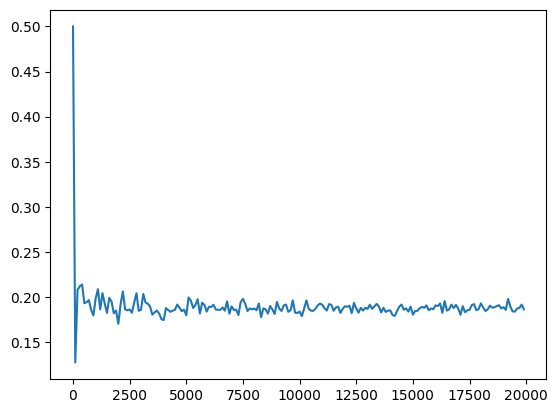

In [25]:
plt.plot(ns, sample_zeros_imp)
np.mean(sample_zeros_imp)

(0.0, 14.0)

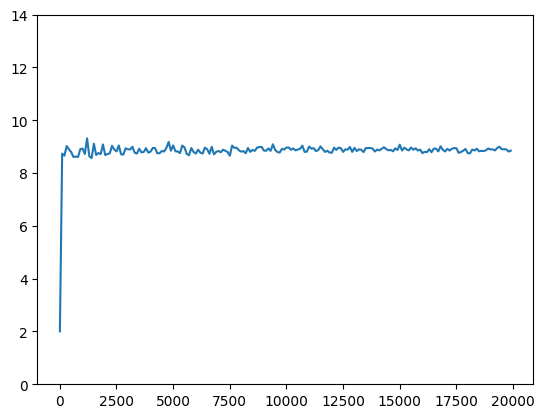

In [26]:
plt.plot(ns, out_imp)
plt.ylim([0, 14])

#### Sobol Paths

In [27]:
out_sobol = np.zeros(len(ns))
sd_samples_sobol = np.zeros(len(ns))
num_zeros_sobol = np.zeros(len(ns))
for i in range(len(ns)):
    num_paths = ns[i]
    sobol_seq_paths = sobol_seq.i4_sobol_generate(1, num_paths)
    Z = norm.ppf(sobol_seq_paths.flatten())
    S_T = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z) - K
    S_T[S_T < 0] = 0
    option_price =  np.exp(-r * T) * np.mean(S_T)
    sd_samples_sobol[i] = np.sqrt(np.var(S_T))/ns[i]
    num_zeros_sobol[i] = np.sum(S_T == 0)/ns[i]
    out_sobol[i] = option_price

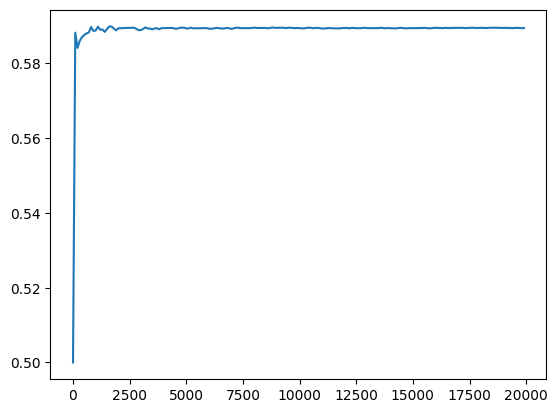

In [28]:
plt.plot(ns, num_zeros_sobol)

In [29]:
np.mean(num_zeros_sobol)

0.5889142073841799

In [30]:
coefs_sobol = np.polyfit(np.log(ns[1:]), np.log(sd_samples_sobol[1:]), 1)
slope_sobol, intercept_sobol = coefs_sobol

In [31]:
np.var(out_normal)

12.271345019003727

In [32]:
np.var(out_anti)

1.1041587397886747

In [33]:
np.var(out_imp)

0.2456478285138501

In [34]:
np.var(out_sobol)

0.03832014193743255

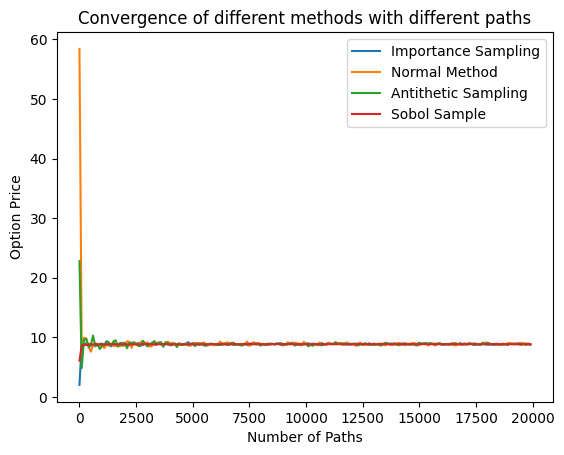

In [35]:
plt.plot(ns, out_imp, label = "Importance Sampling")
plt.plot(ns, out_normal, label = "Normal Method")
plt.plot(ns, out_anti, label = "Antithetic Sampling")
plt.plot(ns, out_sobol, label = "Sobol Sample")
plt.title("Convergence of different methods with different paths")
plt.ylabel("Option Price")
plt.xlabel("Number of Paths")
plt.legend()
plt.show()

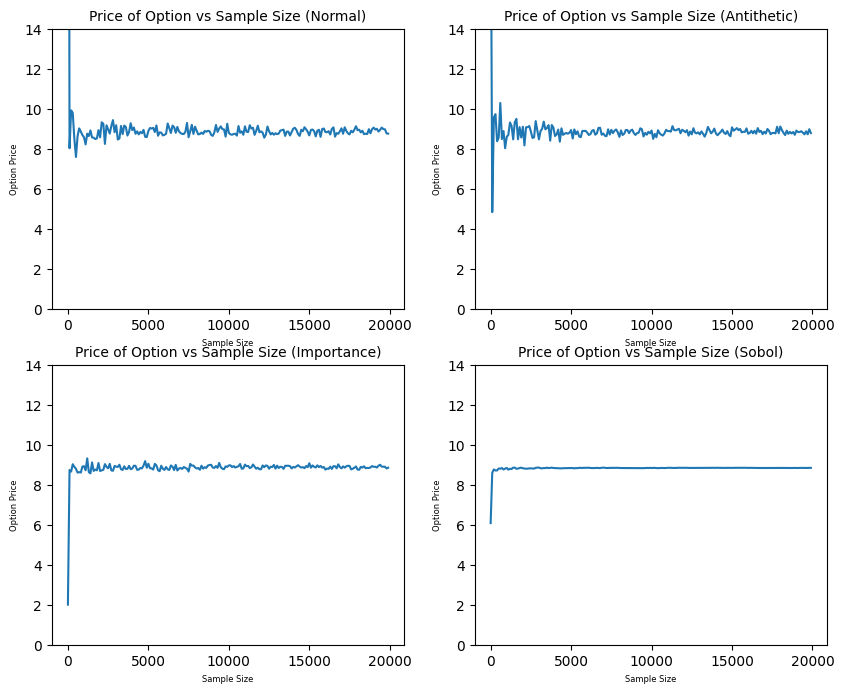

In [36]:
fig, axs = plt.subplots(2, 2, figsize = [10,8])
axs[0,0].plot(ns, out_normal)
axs[0,0].set_title("Price of Option vs Sample Size (Normal)", fontsize = 10)
axs[0,0].set_xlabel("Sample Size", fontsize = 6)
axs[0,0].set_ylabel("Option Price", fontsize = 6)
axs[0,0].set_ylim([0, 14])


axs[0,1].plot(ns, out_anti)
axs[0,1].set_title("Price of Option vs Sample Size (Antithetic)", fontsize = 10)
axs[0,1].set_xlabel("Sample Size", fontsize = 6)
axs[0,1].set_ylabel("Option Price", fontsize = 6)
axs[0,1].set_ylim([0, 14])


axs[1,0].plot(ns, out_imp)
axs[1,0].set_title("Price of Option vs Sample Size (Importance)", fontsize = 10)
axs[1,0].set_xlabel("Sample Size", fontsize = 6)
axs[1,0].set_ylabel("Option Price", fontsize = 6)
axs[1,0].set_ylim([0, 14])



axs[1,1].plot(ns, out_sobol)
axs[1,1].set_title("Price of Option vs Sample Size (Sobol)", fontsize = 10)
axs[1,1].set_xlabel("Sample Size", fontsize = 6)
axs[1,1].set_ylabel("Option Price", fontsize = 6)
axs[1,1].set_ylim([0, 14])

plt.savefig("optionPricevsSampleAll.png")


C:\Users\Joshua\AppData\Local\Temp\ipykernel_3136\1109906297.py:3: RuntimeWarning: divide by zero encountered in log
  axs[0,0].plot(nsl, np.log(sd_samples))


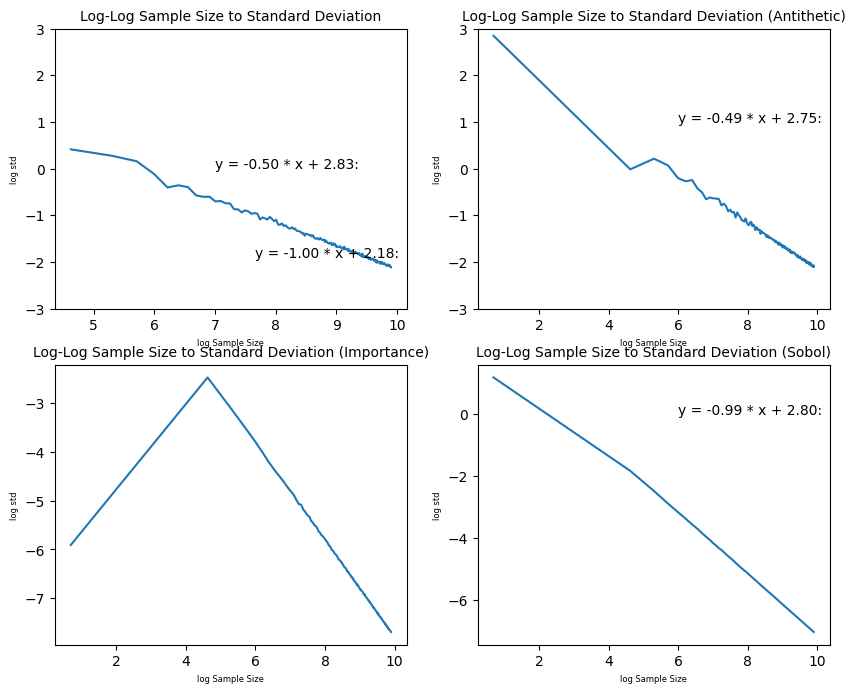

In [37]:
fig, axs = plt.subplots(2, 2, figsize = [10,8])
nsl = np.log(ns)
axs[0,0].plot(nsl, np.log(sd_samples))
axs[0,0].set_title("Log-Log Sample Size to Standard Deviation", fontsize = 10)
axs[0,0].set_xlabel("log Sample Size", fontsize = 6)
axs[0,0].set_ylabel("log std", fontsize = 6)
axs[0,0].set_ylim([-3, 3])
axs[0,0].text(7, 0, f"y = {slope:.2f} * x + {intercept:.2f}:")



axs[0,1].plot(nsl, np.log(sd_samples_anti))
axs[0,1].set_title("Log-Log Sample Size to Standard Deviation (Antithetic)", fontsize = 10)
axs[0,1].set_xlabel("log Sample Size", fontsize = 6)
axs[0,1].set_ylabel("log std", fontsize = 6)
axs[0,1].set_ylim([-3,3])
axs[0,1].text(6, 1, f"y = {slope_anti:.2f} * x + {intercept_anti:.2f}:")



axs[1,0].plot(nsl, np.log(sd_sample_imp))
axs[1,0].set_title("Log-Log Sample Size to Standard Deviation (Importance)", fontsize = 10)
axs[1,0].set_xlabel("log Sample Size", fontsize = 6)
axs[1,0].set_ylabel("log std", fontsize = 6)
axs[1,0].text(6, 0, f"y = {slope_imp:.2f} * x + {intercept_imp:.2f}:")

#axs[1,0].set_ylim([-3,3])



axs[1,1].plot(nsl, np.log(sd_samples_sobol))
axs[1,1].set_title("Log-Log Sample Size to Standard Deviation (Sobol)", fontsize = 10)
axs[1,1].set_xlabel("log Sample Size", fontsize = 6)
axs[1,1].set_ylabel("log std", fontsize = 6)
axs[1,1].text(6, 0, f"y = {slope_sobol:.2f} * x + {intercept_sobol:.2f}:")

#axs[1,1].set_ylim([-3, 3])

plt.savefig("convergeAll.png")


In [38]:
strikes = np.arange(100, 200, 10)
var_imp = np.zeros(len(strikes))
var_normal = np.zeros(len(strikes))
var_anti = np.zeros(len(strikes))
var_sobol = np.zeros(len(strikes))

for strike in range(len(strikes)):
    K = strikes[strike]
    
    N = 5000
    
    ns = np.arange(2, N+1, 100)
    
    out_imp_var = np.zeros(len(ns))
    for i in range(len(ns)):
        sample = np.random.normal(loc = 2, scale = np.sqrt(4), size = ns[i]) 
        weights = P(sample)/Q(sample)
        estimate = np.sum(f(sample, K) * weights) / (ns[i])
        out_imp_var[i] = estimate * np.e ** (-r * T)

    var_imp[strike] = np.var(out_imp_var)

    
    out_anti_var = np.zeros(len(ns))
    
    for i in range(len(ns)):
        sample = np.random.normal(size = int(ns[i]/2))
        sample_inv = -sample
        sample_f = np.concatenate((sample, sample_inv))
        price = - K + S0 * np.e ** ((r - 1/2 * sigma ** 2) * T + sigma * np.sqrt(T) * sample_f)
        price[price < 0] = 0
        out_anti_var[i] = np.mean(price) * np.e ** (-r * T)

    var_anti[strike] = np.var(out_anti_var)

    out_normal_var = np.zeros(len(ns))
    for i in range(len(ns)):
        sample = np.random.normal(size = ns[i])
        price = - K + S0 * np.e ** ((r - 1/2 * sigma ** 2) * T + sigma * np.sqrt(T) * sample)
        price[price < 0] = 0
        out_normal_var[i] = np.mean(price) * np.e ** (-r * T)

    var_normal[strike] = np.var(out_normal_var)

    out_sobol_var = np.zeros(len(ns))
    for i in range(len(ns)):
        num_paths = ns[i]
        sobol_seq_paths = sobol_seq.i4_sobol_generate(1, num_paths)
        Z = norm.ppf(sobol_seq_paths.flatten())
        S_T = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z) - K
        S_T[S_T < 0] = 0
        option_price =  np.exp(-r * T) * np.mean(S_T)
        out_sobol_var[i] = option_price

    var_sobol[strike] = np.var(out_sobol_var)

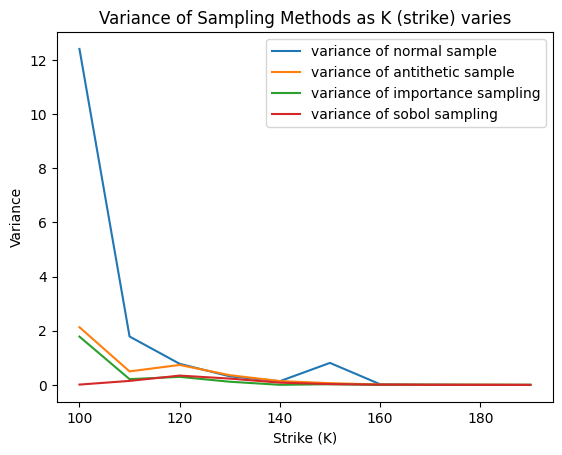

In [39]:
plt.plot(strikes, var_normal, label = "variance of normal sample")
plt.plot(strikes, var_anti, label = "variance of antithetic sample")
plt.plot(strikes, var_imp, label = "variance of importance sampling")
plt.plot(strikes, var_sobol, label = "variance of sobol sampling")

plt.title("Variance of Sampling Methods as K (strike) varies")
plt.ylabel("Variance")
plt.xlabel("Strike (K)")
plt.legend()
plt.savefig("varianceVsK.png")

In [40]:
strikes = np.arange(100, 200, 10)
zeros_imp = np.zeros(len(strikes))
zeros_normal = np.zeros(len(strikes))
zeros_anti = np.zeros(len(strikes))
zeros_sobol = np.zeros(len(strikes))
N = 5000

for i in range(len(strikes)):
    K = strikes[i]
    sample = np.random.normal(size = N)
    price = - K + S0 * np.e ** ((r - 1/2 * sigma ** 2) * T + sigma * np.sqrt(T) * sample)
    price[price < 0] = 0
    zeros_normal[i] = np.sum(price == 0)/N

    sobol_seq_paths = sobol_seq.i4_sobol_generate(1, N)
    Z = norm.ppf(sobol_seq_paths.flatten())
    S_T = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z) - K
    S_T[S_T < 0] = 0
    zeros_sobol[i] = np.sum(S_T == 0)/N

    sample = np.random.normal(size = int(N/2))
    sample_inv = -sample
    sample_f = np.concatenate((sample, sample_inv))
    price = - K + S0 * np.e ** ((r - 1/2 * sigma ** 2) * T + sigma * np.sqrt(T) * sample_f)
    price[price < 0] = 0
    zeros_anti[i] = np.sum(price == 0)/ N

    sample = np.random.normal(loc = 2, scale = np.sqrt(4), size = N) 
    weights = P(sample)/Q(sample)
    prices = - K + S0 * np.e ** ((r - 1/2 * sigma ** 2) * T + sigma * np.sqrt(T) * sample) * weights + 2
    prices[prices<0] = 0
    print(prices)
    zeros_imp[i] = np.sum(prices == 0)/N
    
    
    

[  0.         410.65983127   0.         ...   0.           0.
   0.        ]
[ 0.          0.          0.         ...  0.          0.
 31.88700165]
[  0.           0.           0.         ... 202.53135603   0.
 510.24572981]
[544.75978884   0.           0.         ...   0.         195.29462448
   0.        ]
[  0.           0.         182.84559783 ...   0.           0.
 164.49728411]
[0.00000000e+00 0.00000000e+00 5.42045326e+02 ... 5.36089179e+02
 2.97935406e-01 5.50477324e+02]
[ 0.          0.         55.02683044 ... 33.7395391  83.44916713
  0.        ]
[  0.           0.         504.05124584 ... 343.18223002   0.
   0.        ]
[  0.           0.         399.21498461 ...   0.         460.61617911
 100.26805299]
[426.19795747   0.           0.         ... 501.38975852   0.
   0.        ]


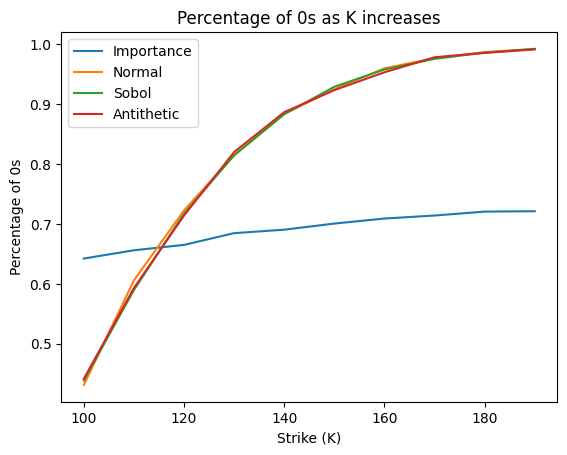

In [41]:
plt.plot(strikes, zeros_imp, label = "Importance")
plt.plot(strikes, zeros_normal, label = "Normal")
plt.plot(strikes, zeros_sobol, label = "Sobol")
plt.plot(strikes, zeros_anti, label = "Antithetic")
plt.title("Percentage of 0s as K increases")
plt.xlabel("Strike (K)")
plt.ylabel("Percentage of 0s")
plt.legend()
plt.savefig("zero_perc.png")

---
## Heston Model SDE
The Heston model is defined by a system of SDEs, to describe the movement of asset prices, where an
asset’s price and volatility follow random, Brownian motion processes (this is under real world measure $\mathbb{P}$): 

$$ dS_t = \mu S_t dt + \sqrt{v_t}S_t dW^\mathbb{P}_{S,t}$$
    
$$ dv_t = \kappa(\theta - v_t)dt +\sigma \sqrt{v_t} dW^\mathbb{P}_{v,t}$$

Where the variables are:
- $\sigma$ volatility of volatility
- $\theta$ long-term price variance
- $\kappa$ rate of reversion to the long-term price variance
- $dW^\mathbb{P}_{S,t}$ Brownian motion of asset price
- $dW^\mathbb{P}_{v,t}$ Brownian motion of asset's price variance
- $\rho^\mathbb{P}$ correlation between $dW^\mathbb{P}_{S,t}$ and $dW^\mathbb{P}_{v,t}$

Dynamics under risk-neutral measure $\mathbb{Q}$:

$$ dS_t = r S_t dt + \sqrt{v_t}S_t dW^\mathbb{Q}_{S,t}$$
    
$$dv_t = \kappa^\mathbb{Q}(\theta^\mathbb{Q} - v_t)dt +\sigma^\mathbb{Q} \sqrt{v_t} dW^\mathbb{Q}_{v,t}$$

#### Euler Discretisation of SDEs
$$ dS_{i+1} = S_i e^{(r-\frac{v_i}{2}) \Delta t + \sqrt{v_{i}}\Delta tW^\mathbb{Q}_{S,i+1}}$$
    
$$ v_{i+1} = v_i + \kappa(\theta - v_t)\Delta t +\sigma \sqrt{v_i} \Delta t W^\mathbb{Q}_{v,i+1}$$

The full truncation Euler scheme has that $v_i = v_i^+$

In [42]:
def heston_model_sim(S0, v0, rho, kappa, theta, sigma,T, N, M, K):
    """
    Outputs:
    - asset prices over time (numpy array)
    - variance over time (numpy array)
    - payoff values (numpy array)
    """
    # initialise other parameters
    dt = T/N
    mu = np.array([0,0])
    cov = np.array([[1,rho],
                    [rho,1]])

    # arrays for storing prices and variances - N+1 time steps and M sims
    S = np.full(shape=(N+1,M), fill_value=S0)
    v = np.full(shape=(N+1,M), fill_value=v0)
    
    # Monte Carlo Simulation
    # sampling correlated brownian motions under risk-neutral measure
    Z = np.random.multivariate_normal(mu, cov, (N,M))
    
    vals = np.empty(N)
    
    # Euler discretisation as 
    for i in range(1,N+1):
        S[i] = S[i-1] * np.exp( (r - 0.5*v[i-1])*dt + np.sqrt(v[i-1] * dt) * Z[i-1,:,0] )
        
        # Note: using the FULL TRUNCATION Euler scheme
        # as opposed to reflection or partial truncation
        v[i] = np.maximum(v[i-1] + kappa*(theta-v[i-1])*dt + sigma*np.sqrt(v[i-1]*dt)*Z[i-1,:,1],0)
        
    # Calculate the payoff at maturity for each simulation
    payoff = np.maximum(S[-1] - K, 0)
    
    return S, v, payoff

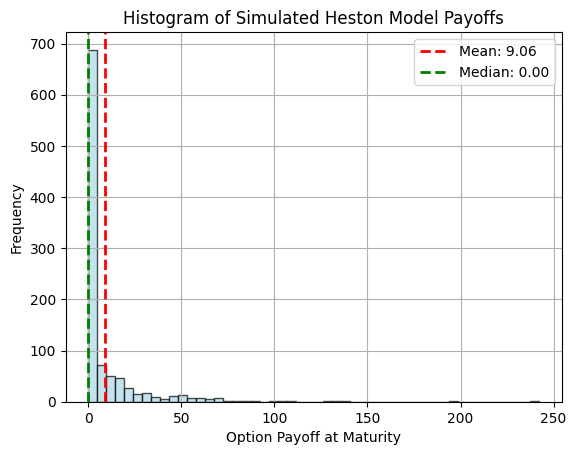

In [43]:
# Initial parameters
# simulation dependent
S0 = 100.0             # asset price
T = 1.0                # time in years
r = 0.02               # risk-free rate
N = 252                # number of time steps in simulation
M = 1000               # number of simulations
K = 100

# Heston dependent parameters
kappa = 3              # rate of mean reversion of variance under risk-neutral dynamics
theta = 0.20**2        # long-term mean of variance under risk-neutral dynamics - 20% squared
v0 = 0.25**2           # initial variance under risk-neutral dynamics
rho = 0.7              # correlation between returns and variances under risk-neutral dynamics
sigma = 0.6            # volatility of volatility - fairly high

S_1,v_1, payoff = heston_model_sim(S0, v0, rho, kappa, theta, sigma, T, N, M, K = 100)

# Compute the mean and median of the option payoffs
mean_val = np.mean(payoff)
median_val = np.median(payoff)

# Plot histogram of the option payoff values at maturity
plt.plot(figsize=(6,4))
plt.hist(payoff, bins=50, color="lightblue", edgecolor='black', alpha=0.7)
plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_val:.2f}')
plt.title("Histogram of Simulated Heston Model Payoffs")
plt.xlabel("Option Payoff at Maturity")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

In [44]:
stock = "AAPL"
tk = yf.Ticker(stock)

calls = pd.read_csv("calls_2024-09-27.csv")     #Read in data
calls

mu = 0.21668014545292205         # Drift rate of the stock price
kappa = 3.7442       # Rate of mean reversion
theta = 0.24291637987256323       # Long-term variance
sigma = 0.07835555563743023    # Volatility of variance
rho = -0.42075502643850055        # Correlation between stock price and variance
S0 = tk.info["currentPrice"]          # Initial stock price
T =  18/256          # Time 
N = 1000          # Number of steps
dt = T / N        # step size
M = 10000        #Number of iterations
r = 0.053      # IR
strikes = calls.strike
iv = calls.impliedVolatility          # Initial vol

In [45]:
# Convergence plot for market data

----
## Finite Difference Method Using Heston PDE
Here, we will work with the Heston PDE, and apply finite difference methods to it for different options.

The Heston SDE is given by:

$$
\begin{align*}
dS_t &= rS_tdt + \sqrt{V_t}S_tdW_t^1\\
dV_t &= \kappa(\theta-V_t)dt + \sigma\sqrt{V_t}dW_t^2\\
dW_t^1dW_t^2&=\rho dt
\end{align*}
$$

The corresponding PDE is given by:
$$
\frac{1}{2}\sigma^2V\frac{\partial^2U}{\partial V^2} + \sigma SV\rho\frac{\partial^2U}{\partial S\partial V} + \frac{1}{2}VS^2\frac{\partial^2U}{\partial S^2} + \kappa(\theta-V)\frac{\partial U}{\partial V} + rS\frac{\partial U}{\partial S} + \frac{\partial U}{\partial t} - rU = 0
$$

where $U$ is the price of the option with respect to the underlying asset $S$ and volatility $V$.
Provided that $\frac{2\kappa\eta}{\sigma^2}<1$ and $\Delta t < \frac{1}{2}\left(\frac{\Delta S^2}{VS^2}+\frac{\Delta V^2}{\sigma^2 V}\right)$, the volatility is strictly positive and the method will remain stable.

### Forward Difference Method


Space discretisation:

Using central differences, we can approximate the derivatives by:

$$
\begin{align*}
\left(\frac{\partial u}{\partial s}\right)_{i,j} &= \frac{u_{i+1,j}-u_{i-1,j}}{2\Delta s} + \mathcal{O}(\Delta s^2)\\
\left(\frac{\partial^2 u}{\partial s^2}\right)_{i,j} &= \frac{u_{i+1,j}-2u_{i,j}+u_{i-1,j}}{\Delta s^2} + \mathcal{O}(\Delta s^2)\\
\left(\frac{\partial u}{\partial v}\right)_{i,j} &= \frac{u_{i,j+1}-u_{i,j-1}}{2\Delta v} + \mathcal{O}(\Delta v^2)\\
\left(\frac{\partial^2 u}{\partial v^2}\right)_{i,j} &= \frac{u_{i,j+1}-2u_{i,j}+u_{i,j-1}}{\Delta v^2} + \mathcal{O}(\Delta v^2)\\
\left(\frac{\partial^2u}{\partial s\partial v}\right)_{i,j} &= \frac{u_{i+1,j+1}-u_{i-1,j+1}-u_{i+1,j-1}+u_{i-1,j-1}}{4\Delta v\Delta s} + \text{error}
\end{align*}
$$

**To improve stability (prevent oscillations), we will switch to the backward difference scheme when $\kappa(\theta-v)<0$.**
$$
\left(\frac{\partial u}{\partial v}\right)_{i,j} = \frac{u_{i,j-2}-4u_{i,j-1}+3u_{i,j}}{2\Delta v} + \mathcal{O}(\Delta v^2)
$$

Time discretisation:

Set $\tau=T-t$. When using the forward-difference scheme, we can approximate the derivative by:

$$
\left(\frac{\partial u}{\partial \tau}\right)^k = \frac{u^{k+1}-u^k}{\Delta t} + \mathcal{O}(\Delta t)
$$
and so

$$
u^{k+1}_{i,j} = u^k_{i,j} + \Delta t f(u_{i,j}^k)
$$
where
$$
f(u_{i,j}^k) = \frac{1}{2}\sigma^2v\left(\frac{u_{i,j+1}^k-2u_{i,j}^k+u_{i,j-1}^k}{\Delta v^2}\right) + \sigma sv\rho\left(\frac{u_{i+1,j+1}^k-u_{i-1,j+1}^k-u_{i+1,j-1}^k+u_{i-1,j-1}^k}{4\Delta v\Delta s}\right) + \frac{1}{2}vs^2\left(\frac{u_{i+1,j}^k-2u_{i,j}^k+u_{i-1,j}^k}{\Delta s^2}\right) + \kappa(\theta-v)\left(\frac{u_{i,j+1}^k-u_{i,j-1}^k}{2\Delta v}\right) + rs\left(\frac{u_{i+1,j}^k-u_{i-1,j}^k}{2\Delta s}\right) - ru^k_{i,j}
$$

Keep in mind that we are working backwards, i.e. $k=0$ means $t=T$. Thus, to compute the solution we will compute the solution if $u_{i,j}^k$ in a grid for $s$ and $v$, and then iterate over time.

Boundary Conditions:

For a European call option, the boundary conditions are:

$$
\begin{align*}
&u(0,v,\tau) = 0\\
&u(s, V_{\text{max}},\tau)=s\\
&\frac{\partial }{\partial s}u(S_{\text{max}},v,\tau)=1\\
&\frac{\partial u}{\partial \tau}(s,0,\tau)=\kappa\theta\frac{\partial u}{\partial v}(s,0,\tau) + rs\frac{\partial u}{\partial s}(s,0,\tau)-ru(s,0,\tau)\\
&u(s,v,0) = \max(s-K,0)\\
\end{align*}
$$

#### Example 1
In our case, choose $S_{\text{max}}=300$, $\kappa=3.7442$, $V_{\text{max}}=1.7$, $\theta=0.243$, $r=0.0533$, $T=1$, $\sigma=0.0784$, $K=200$, $\rho=-0.42$, $T=18/256$.

The analytical solution with $S_0=220.82$, $v_0=0.47$ is \$26.5,

For our simulation, we will discretise $s$, $v$ and $\tau$ into 50, 50 and 5000 values respectively.

In [46]:
# Option parameters
Smax = 300
kappa = 3.7442  # Mean reversion rate
Vmax = 1.7
theta = 0.24291637987256323 # Long term variance
r = 0.0533 # Risk free rate
T = 18/256  # Expiry
sigma = 0.07835555563743023 # Volatility of volatility
K = 200 # Strike price
rho = -0.42075502643850055 # Correlation between brownian motions

# Simulation parameters
N = 50 # number of s values
M = 50 # number of v values
L = 5000 # number of tau (t) values

ds = Smax/N
dv = Vmax/M
dt = T/L

In [47]:
# Initialise s, v, tau, u
s = np.arange(N+1)*ds # Range of underlying stock prices
v = np.arange(M+1)*dv # Range of volatility values
tau = np.arange(L+1)*dt # Range of time values
u = np.zeros((N+1, M+1, L+1)) # Option price (to be computed)

# Apply initial conditions
for i in range(N+1):
    for j in range(M+1):
        u[i, j, 0] = max(s[i] - K, 0) # Condition 5

# Apply boundary conditions
for n in range(L):
    for j in range(M+1):
        u[0, j, n+1] = 0  # Condition 1

    for i in range(N+1):
        u[i, M, n+1] = s[i] # Condition 2     

# Perform simulation
# Explicit Euler scheme
for n in range(L):
    for i in range(1, N):
        for j in range(M):
            # Approximate derivatives
            d2u_ds2 = (u[i+1, j, n] - 2*u[i, j, n] + u[i-1, j, n]) / ds**2
            d2u_dv2 = (u[i, j+1, n] - 2*u[i, j, n] + u[i, max(j-1,0), n]) / dv**2

            du_ds = (u[i+1, j, n] - u[i-1, j, n]) / (2*ds)
            if theta-v[j]<0: # Apply backward difference
                du_dv = (u[i, j-2, n] - 4*u[i, j-1, n] + 3*u[i, j, n]) / (2*dv)
            else: # Apply central difference
                du_dv = (u[i, j+1, n] - u[i, max(j-1,0), n]) / (2*dv)
            cross_term = (u[i+1, j+1, n] - u[i-1, j+1, n] - u[i+1, j-1, n] + u[i-1, max(j-1,0), n]) / (4*ds*dv)
            
            # Evaluate u
            if j==0: # Condition 4
                u[i, 0, n+1] = u[i, 0, n] + dt * (
                kappa * theta * (u[i, 1, n] - u[i, 0, n]) / dv +
                r * s[i] * (u[i+1, 0, n] - u[i-1, 0, n]) / (2*ds) -
                r * u[i, 0, n]
                )
            else:
                u[i, j, n+1] = u[i, j, n] + dt * (
                r * s[i] * du_ds +
                kappa * (theta - v[j]) * du_dv +
                0.5 * sigma**2 * v[j] * d2u_dv2 +
                0.5 * v[j] * s[i]**2 * d2u_ds2 +
                rho * sigma * s[i] * v[j] * cross_term -
                r * u[i, j, n]
                )
    # Condition 3
    for j in range(M):
        u[N, j, n+1] = u[N-1, j, n+1] + ds
    
    # Boundary condition v=Vmax
    for i in range(N+1):
        u[i, M, n+1] = u[i, M-1, n+1]

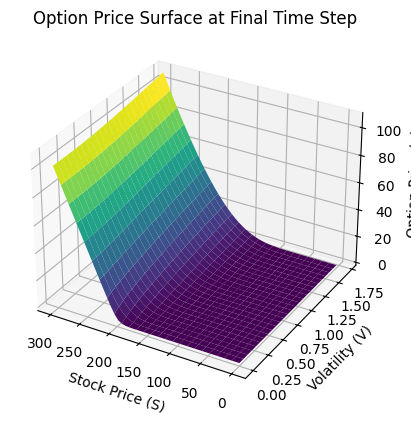

In [48]:
# Create meshgrid for plotting
S, V = np.meshgrid(np.arange(N+1) * ds, np.arange(M+1) * dv)

# Extract the option prices at the final time step
U_final = u[:, :, -1]

# Plotting the surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(S, V, U_final.T, cmap='viridis')

# Adding labels and title
ax.set_xlabel('Stock Price (S)')
ax.set_ylabel('Volatility (V)')
ax.set_zlabel('Option Price (u)')
ax.set_title('Option Price Surface at Final Time Step')

ax.invert_xaxis()

# Show the plot
plt.show()


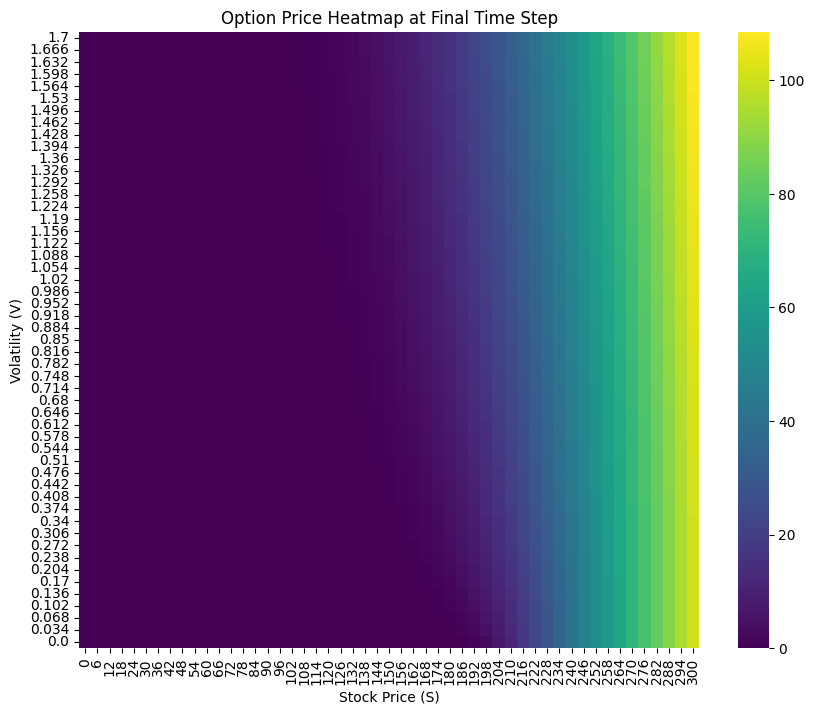

In [49]:
# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(U_final.T, xticklabels=(np.arange(N+1) * ds).astype(int), yticklabels=(np.arange(M+1)* dv).round(3), cmap='viridis')

# Adding labels and title
plt.xlabel('Stock Price (S)')
plt.ylabel('Volatility (V)')
plt.title('Option Price Heatmap at Final Time Step')

plt.gca().invert_yaxis()

# Show the plot
plt.savefig("headmapFinalStep.png")

In [50]:
# Compare to analytical solution of 26.5, S0=220.82 (ATM), v=0.47, K=200
print(u[37,14,-1])

28.960227048275335


As we can see, options with a higher starting price and volatility are worth more, which makes sense since we would expect to see a higher payoff.

Let's look at how well the algorithm converges to a solution, as $\Delta t\to 0$:

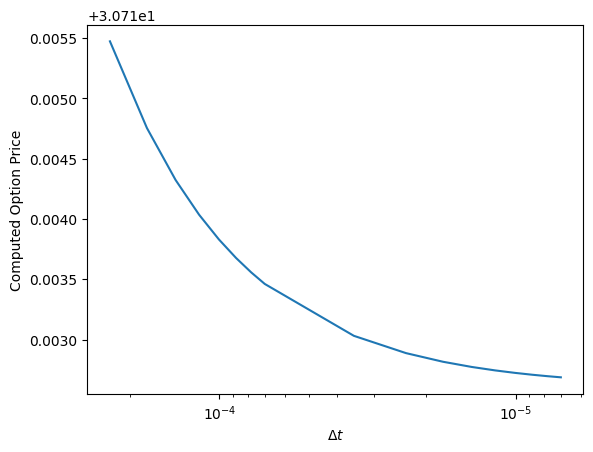

In [51]:
# Convergence of solution as dt decreases
values = (300, 400, 500, 600, 700, 800, 900,
          1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000,
          10000)
computed = np.zeros(len(values))
for ind, L in enumerate(values):
    # Simulation parameters
    N = 20 # number of s values
    M = 20 # number of v values
    
    ds = Smax/N
    dv = Vmax/M
    dt = T/L
    # Initialise s, v, tau, u
    s = np.arange(N+1)*ds # Range of underlying stock prices
    v = np.arange(M+1)*dv # Range of volatility values
    tau = np.arange(L+1)*dt # Range of time values
    u = np.zeros((N+1, M+1, L+1)) # Option price (to be computed)

    # Apply initial conditions
    for i in range(N+1):
        for j in range(M+1):
            u[i, j, 0] = max(s[i] - K, 0) # Condition 5

    # Apply boundary conditions
    for n in range(L):
        for j in range(M+1):
            u[0, j, n+1] = 0  # Condition 1

        for i in range(N+1):
            u[i, M, n+1] = s[i] # Condition 2     

    # Perform simulation
    # Explicit Euler scheme
    for n in range(L):
        for i in range(1, N):
            for j in range(M):
                # Approximate derivatives
                d2u_ds2 = (u[i+1, j, n] - 2*u[i, j, n] + u[i-1, j, n]) / ds**2
                d2u_dv2 = (u[i, j+1, n] - 2*u[i, j, n] + u[i, max(j-1,0), n]) / dv**2

                du_ds = (u[i+1, j, n] - u[i-1, j, n]) / (2*ds)
                if theta-v[j]<0: # Apply backward difference
                    du_dv = (u[i, j-2, n] - 4*u[i, j-1, n] + 3*u[i, j, n]) / (2*dv)
                else: # Apply central difference
                    du_dv = (u[i, j+1, n] - u[i, max(j-1,0), n]) / (2*dv)
                cross_term = (u[i+1, j+1, n] - u[i-1, j+1, n] - u[i+1, j-1, n] + u[i-1, max(j-1,0), n]) / (4*ds*dv)

                # Evaluate u
                if j==0: # Condition 4
                    u[i, 0, n+1] = u[i, 0, n] + dt * (
                    kappa * theta * (u[i, 1, n] - u[i, 0, n]) / dv +
                    r * s[i] * (u[i+1, 0, n] - u[i-1, 0, n]) / (2*ds) -
                    r * u[i, 0, n]
                    )
                else:
                    u[i, j, n+1] = u[i, j, n] + dt * (
                    r * s[i] * du_ds +
                    kappa * (theta - v[j]) * du_dv +
                    0.5 * sigma**2 * v[j] * d2u_dv2 +
                    0.5 * v[j] * s[i]**2 * d2u_ds2 +
                    rho * sigma * s[i] * v[j] * cross_term -
                    r * u[i, j, n]
                    )
        # Condition 3
        for j in range(M):
            u[N, j, n+1] = u[N-1, j, n+1] + ds

        # Boundary condition v=Vmax
        for i in range(N+1):
            u[i, M, n+1] = u[i, M-1, n+1]
    # Extract value
    computed[ind] = u[15,5,-1]

# Plot of results
plt.plot(T/np.array(values), computed)
plt.xlabel(r"$\Delta t$")
plt.ylabel("Computed Option Price")
plt.xscale("log")

plt.gca().invert_xaxis()

plt.savefig("Option_cd_conv.png")

#### Example 2 - Up and out option

We will now consider an up and out option.
All that changes here is our boundary conditions. We now have:

$$
\begin{align*}
&u(0,v,\tau) = 0\\
&u(s, V_{\text{max}},\tau)=0\\
&u(B=S_{\text{max}},v,\tau)=0\\
&\frac{\partial u}{\partial \tau}(s,0,\tau)=\kappa\theta\frac{\partial u}{\partial v}(s,0,\tau) + rs\frac{\partial u}{\partial s}(s,0,\tau)-ru(s,0,\tau)\\
&u(s,v,0) = \max(s-K,0)\\
\end{align*}
$$

Using the same parameters as before (and setting $B=S_\max=250$), we get:

In [52]:
# Option parameters
Smax = 250
kappa = 3.7442  # Mean reversion rate
Vmax = 1.7
theta = 0.24291637987256323 # Long term variance
r = 0.0533 # Risk free rate
T = 18/256  # Expiry
sigma = 0.07835555563743023 # Volatility of volatility
K = 200 # Strike price
rho = -0.42075502643850055 # Correlation between brownian motions

# Simulation parameters
N = 50 # number of s values
M = 50 # number of v values
L = 5000 # number of tau (t) values

ds = Smax/N # Gap between stock prices
dv = Vmax/M # Gap between volatility values
dt = T/L # Time discretisation

In [53]:
# Initialise s, v, tau, u
s = np.arange(N+1)*ds # Range of underlying stock prices
v = np.arange(M+1)*dv # Range of volatility values
tau = np.arange(L+1)*dt # Range of time values
u = np.zeros((N+1, M+1, L+1)) # Option price (to be computed)

# Apply initial conditions
for i in range(N+1):
    for j in range(M+1):
        u[i, j, 0] = max(s[i] - K, 0) # 5th condition

# Apply boundary conditions
for n in range(L):
    for j in range(M+1):
        u[0, j, n+1] = 0  # 1st condition
        u[N, j, n+1] = 0  # 3rd condition

    for i in range(N+1):
        u[i, M, n+1] = 0 # 2nd condition      

# Perform simulation
# Explicit Euler scheme
for n in range(L):
    for i in range(1, N):
        for j in range(M):
            # Approximate derivatives
            d2u_ds2 = (u[i+1, j, n] - 2*u[i, j, n] + u[i-1, j, n]) / ds**2
            d2u_dv2 = (u[i, j+1, n] - 2*u[i, j, n] + u[i, max(j-1,0), n]) / dv**2

            du_ds = (u[i+1, j, n] - u[i-1, j, n]) / (2*ds)
            if theta-v[j]<0: # Apply backward difference
                du_dv = (u[i, j-2, n] - 4*u[i, j-1, n] + 3*u[i, j, n]) / (2*dv)
            else: # Apply central difference
                du_dv = (u[i, j+1, n] - u[i, max(j-1,0), n]) / (2*dv)
            cross_term = (u[i+1, j+1, n] - u[i-1, j+1, n] - u[i+1, j-1, n] + u[i-1, max(j-1,0), n]) / (4*ds*dv)
            
            # Evaluate u
            if j==0: # Condition 4
                u[i, 0, n+1] = u[i, 0, n] + dt * (
                kappa * theta * (u[i, 1, n] - u[i, 0, n]) / dv +
                r * s[i] * (u[i+1, 0, n] - u[i-1, 0, n]) / (2*ds) -
                r * u[i, 0, n]
                )
            else:
                u[i, j, n+1] = u[i, j, n] + dt * (
                r * s[i] * du_ds +
                kappa * (theta - v[j]) * du_dv +
                0.5 * sigma**2 * v[j] * d2u_dv2 +
                0.5 * v[j] * s[i]**2 * d2u_ds2 +
                rho * sigma * s[i] * v[j] * cross_term -
                r * u[i, j, n]
                )
           

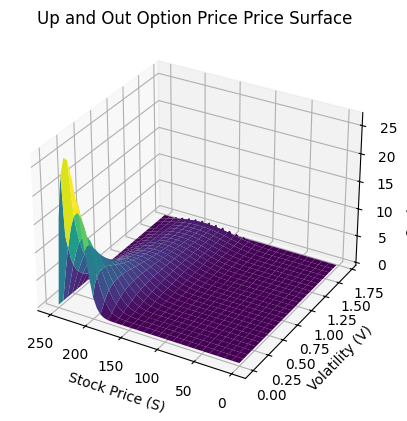

In [54]:
S, V = np.meshgrid(np.arange(N+1) * ds, np.arange(M+1) * dv)

# Option prices at t=0
U_final = u[:, :, -1]

# Plotting the surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(S, V, U_final.T, cmap='viridis')
ax.set_xlabel('Stock Price (S)')
ax.set_ylabel('Volatility (V)')
ax.set_zlabel('Option Price (u)')
ax.set_title('Up and Out Option Price Price Surface')

ax.invert_xaxis()

plt.show()

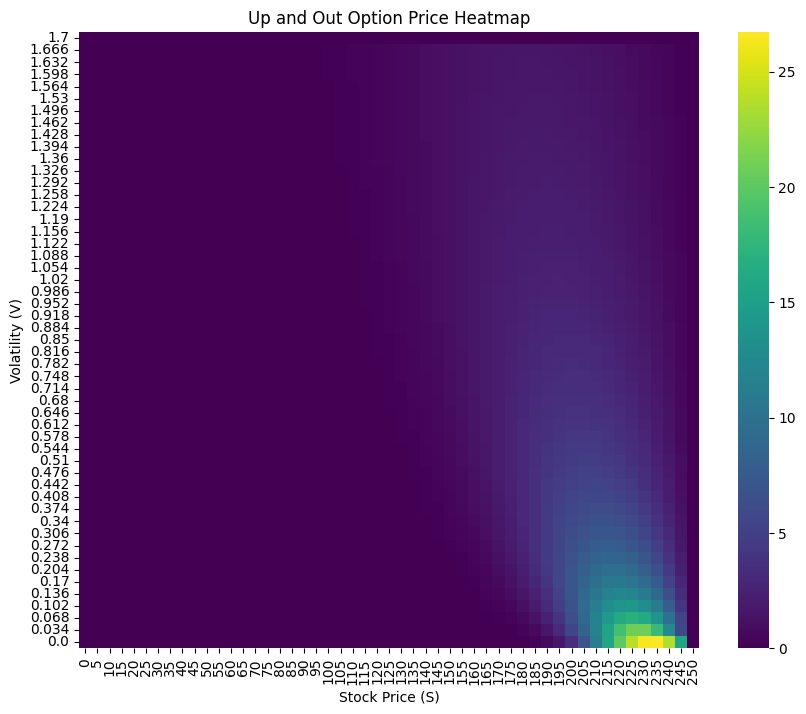

In [55]:
# Plot of heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(U_final.T, xticklabels=(np.arange(N+1) * ds).astype(int), yticklabels=(np.arange(M+1)* dv).round(3), cmap='viridis')
plt.xlabel('Stock Price (S)')
plt.ylabel('Volatility (V)')
plt.title('Up and Out Option Price Heatmap')

plt.gca().invert_yaxis()

plt.show()

In [56]:
# Price for S0=220.82 (ATM), v=0.47, K=200
print(u[37,14,-1])

3.60506486113329


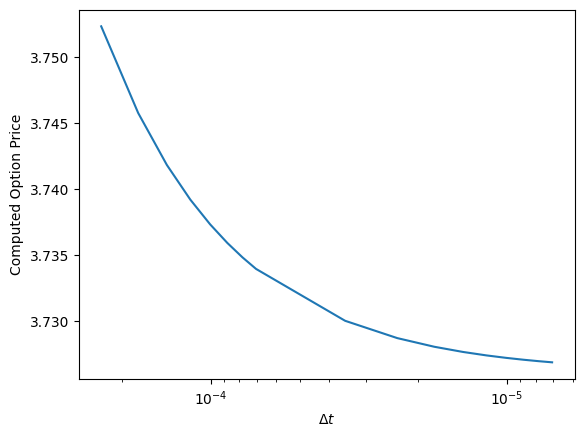

In [57]:
# Convergence of solution as dt decreases
values = (300, 400, 500, 600, 700, 800, 900,
          1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000,
          10000)
computed = np.zeros(len(values))
for ind, L in enumerate(values):
    # Simulation parameters
    N = 20 # number of s values
    M = 20 # number of v values
    
    ds = Smax/N
    dv = Vmax/M
    dt = T/L
    # Initialise s, v, tau, u
    s = np.arange(N+1)*ds # Range of underlying stock prices
    v = np.arange(M+1)*dv # Range of volatility values
    tau = np.arange(L+1)*dt # Range of time values
    u = np.zeros((N+1, M+1, L+1)) # Option price (to be computed)

    # Apply initial conditions
    for i in range(N+1):
        for j in range(M+1):
            u[i, j, 0] = max(s[i] - K, 0) # 5th condition

    # Apply boundary conditions
    for n in range(L):
        for j in range(M+1):
            u[0, j, n+1] = 0  # 1st condition
            u[N, j, n+1] = 0  # 3rd condition

        for i in range(N+1):
            u[i, M, n+1] = 0 # 2nd condition      

    # Perform simulation
    # Explicit Euler scheme
    for n in range(L):
        for i in range(1, N):
            for j in range(M):
                # Approximate derivatives
                d2u_ds2 = (u[i+1, j, n] - 2*u[i, j, n] + u[i-1, j, n]) / ds**2
                d2u_dv2 = (u[i, j+1, n] - 2*u[i, j, n] + u[i, max(j-1,0), n]) / dv**2

                du_ds = (u[i+1, j, n] - u[i-1, j, n]) / (2*ds)
                if theta-v[j]<0: # Apply backward difference
                    du_dv = (u[i, j-2, n] - 4*u[i, j-1, n] + 3*u[i, j, n]) / (2*dv)
                else: # Apply central difference
                    du_dv = (u[i, j+1, n] - u[i, max(j-1,0), n]) / (2*dv)
                cross_term = (u[i+1, j+1, n] - u[i-1, j+1, n] - u[i+1, j-1, n] + u[i-1, max(j-1,0), n]) / (4*ds*dv)

                # Evaluate u
                if j==0: # Condition 4
                    u[i, 0, n+1] = u[i, 0, n] + dt * (
                    kappa * theta * (u[i, 1, n] - u[i, 0, n]) / dv +
                    r * s[i] * (u[i+1, 0, n] - u[i-1, 0, n]) / (2*ds) -
                    r * u[i, 0, n]
                    )
                else:
                    u[i, j, n+1] = u[i, j, n] + dt * (
                    r * s[i] * du_ds +
                    kappa * (theta - v[j]) * du_dv +
                    0.5 * sigma**2 * v[j] * d2u_dv2 +
                    0.5 * v[j] * s[i]**2 * d2u_ds2 +
                    rho * sigma * s[i] * v[j] * cross_term -
                    r * u[i, j, n]
                    )           
    # Extract value
    computed[ind] = u[15,5,-1]

# Plot of results
plt.plot((T/np.array(values)), computed)
plt.xlabel(r"$\Delta t$")
plt.ylabel("Computed Option Price")
plt.xscale("log")

plt.gca().invert_xaxis()

plt.show()

---
#### Market Data

In [58]:
stock = "AAPL"
tk = yf.Ticker(stock)

In [59]:
calls = pd.read_csv("calls_2024-09-27.csv")
calls

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,AAPL240927C00100000,2024-08-26 16:10:13+00:00,100.0,125.60,124.65,125.30,0.000000,0.000000,NaN,1,1.697267,True,REGULAR,USD
1,AAPL240927C00105000,2024-08-27 15:00:16+00:00,105.0,124.15,119.65,120.35,0.000000,0.000000,NaN,0,1.613283,True,REGULAR,USD
2,AAPL240927C00110000,2024-08-19 13:30:07+00:00,110.0,115.93,114.70,115.40,0.000000,0.000000,10.0,10,1.540041,True,REGULAR,USD
3,AAPL240927C00130000,2024-08-27 15:22:23+00:00,130.0,99.40,95.20,95.85,0.000000,0.000000,NaN,0,1.322025,True,REGULAR,USD
4,AAPL240927C00140000,2024-08-28 18:27:53+00:00,140.0,86.81,84.80,85.30,0.000000,0.000000,2.0,4,1.075200,True,REGULAR,USD
5,AAPL240927C00150000,2024-08-26 15:24:32+00:00,150.0,76.82,74.90,75.40,1.089996,1.439319,1.0,57,0.959717,True,REGULAR,USD
6,AAPL240927C00160000,2024-08-30 15:33:02+00:00,160.0,68.60,64.90,65.80,0.000000,0.000000,2.0,37,0.862550,True,REGULAR,USD
7,AAPL240927C00165000,2024-08-30 15:31:42+00:00,165.0,63.62,60.10,60.70,0.000000,0.000000,1.0,3,0.805422,True,REGULAR,USD
8,AAPL240927C00170000,2024-09-03 14:06:20+00:00,170.0,56.76,55.10,55.50,-1.320004,-2.272733,6.0,8,0.728274,True,REGULAR,USD
9,AAPL240927C00175000,2024-08-28 17:55:06+00:00,175.0,52.65,50.25,50.95,0.000000,0.000000,1.0,3,0.704593,True,REGULAR,USD


In [60]:
strikes = calls.strike
iv = calls.impliedVolatility
simulated_price = np.zeros(len(strikes))
N = 10000
s0 = tk.info.get('currentPrice')
T = 18/256
r = 0.0533 # Per annum
sigma = 0.47
for strike_index in range(len(strikes)):
    sigma = iv[strike_index]
    K = strikes[strike_index]
    sample = np.random.normal(size = N)
    price = - K + s0 * np.e ** ((r - 1/2 * sigma ** 2) * T + sigma * np.sqrt(T) * sample)
    price[price < 0] = 0
    simulated_price[strike_index] = np.mean(price) * np.e ** (-r * T)

In [61]:
# Sobol
simulated_price_sobol = np.zeros(len(strikes))

out_sobol = np.zeros(len(strikes))
for strike_index in range(len(strikes)):
    sigma = iv[strike_index]
    K = strikes[strike_index]
    sobol_seq_paths = sobol_seq.i4_sobol_generate(1, num_paths)
    Z = norm.ppf(sobol_seq_paths.flatten())
    S_T = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z) - K
    S_T[S_T < 0] = 0
    simulated_price_sobol[strike_index] = np.mean(S_T) * np.e ** (-r * T)




In [62]:
strikes = calls.strike
iv = calls.impliedVolatility
simulated_price_anti = np.zeros(len(strikes))
N = 10000
s0 = tk.info.get('currentPrice')
T = 18/256
r = 0.0533 # Per annum
sigma = 0.47
for strike_index in range(len(strikes)):
    sigma = iv[strike_index]
    K = strikes[strike_index]
    sample1 = np.random.normal(size = int(N/2))
    sample2 = -sample1
    sample_f = np.concatenate((sample1, sample2))
    price = - K + s0 * np.e ** ((r - 1/2 * sigma ** 2) * T + sigma * np.sqrt(T) * sample_f)
    price[price < 0] = 0
    simulated_price_anti[strike_index] = np.mean(price) * np.e ** (-r * T)

In [63]:
mu = 0.21668014545292205         # Drift rate of the stock price
kappa = 3.7442       # Rate of mean reversion
theta = 0.24291637987256323       # Long-term varianc
sigma = 0.07835555563743023    # Volatility of variance
rho = -0.42075502643850055        # Correlation between stock price and variance
S0 = tk.info["currentPrice"]          # Initial stock price
T =  18/256          # Time 
N = 100        # prev 1000 Number of steps
dt = T / N        # step size
M = 1000      # prev 10000 Number of iterations
r = 0.0533      # IR
strikes = calls.strike
iv = calls.impliedVolatility          # Initial vol

final_vals = np.zeros(len(strikes))

for strike_index in range(len(strikes)):
    V0 = iv[strike_index]
    K = strikes[strike_index]
    payoffs = np.zeros(M)
    for j in range(M):
        S = S0
        V = V0
        
        for i in range(N):
            dW_S = np.random.normal() * np.sqrt(dt)
            dW_V = np.random.normal() * np.sqrt(dt)
            dW_V = rho * dW_S + np.sqrt(1 - rho**2) * dW_V
            V += kappa * (theta - V) * dt + sigma * np.sqrt(V) * dW_V + 0.5 * sigma * (1 / (2 * np.sqrt(V))) * ((dW_V**2) - dt)
            V = max(V, 0) 
            S += r * S * dt + np.sqrt(V) * S * dW_S + 0.25 * np.sqrt(V) * S * ((dW_S**2) - dt)
        
        payoffs[j] = max(S - K, 0)
    option_price = np.exp(-r * T) * np.mean(payoffs)
    final_vals[strike_index] = option_price

In [64]:
# Starting parameters
strikes = calls.strike
iv = calls.impliedVolatility          # Initial vol

# simulation dependent
S0 = tk.info["currentPrice"]             # asset price
T = 18/256            # time in years
r = 0.053               # risk-free rate
N = 1000                # number of time steps in simulation
M = 10000               # number of simulations

K = strikes
v0 = iv           # initial variance under risk-neutral dynamics

#mu = 0.21668014545292205         # Drift rate of the stock price
kappa = 3.7442       # Rate of mean reversion
theta = 0.24291637987256323 # Long-term variance
sigma = 0.07835555563743023    # Volatility of variance
rho = -0.42075502643850055        # Correlation between stock price and variance

In [65]:
def heston_model_sim(S0, v0, rho, kappa, theta, sigma,T, N, M, K):
    """
    Outputs:
    - asset prices over time (numpy array)
    - variance over time (numpy array)
    - price values (numpy array)
    """
    # initialise other parameters
    dt = T/N
    mu = np.array([0,0])
    cov = np.array([[1,rho],
                    [rho,1]])

    # arrays for storing prices and variances - N+1 time steps and M sims
    S = np.full(shape=(N+1,M), fill_value=S0)
    v = np.full(shape=(N+1,M), fill_value=v0)
    
    # Monte Carlo Simulation
    # sampling correlated brownian motions under risk-neutral measure
    Z = np.random.multivariate_normal(mu, cov, (N,M))
    
    vals = np.empty(N)
    
    # Euler discretisation as 
    for i in range(1,N+1):
        S[i] = S[i-1] * np.exp( (r - 0.5*v[i-1])*dt + np.sqrt(v[i-1] * dt) * Z[i-1,:,0] )
        # Note: using the FULL TRUNCATION Euler scheme
        # as opposed to reflection or partial truncation
        v[i] = np.maximum(v[i-1] + kappa*(theta-v[i-1])*dt + sigma*np.sqrt(v[i-1]*dt)*Z[i-1,:,1],0)
        
    # Calculate the payoff at maturity for each simulation
    vals = np.maximum(S[-1] - K, 0)
    option_price = np.mean(vals) * np.e ** (-r * T)
    
    return S, v, option_price

In [66]:
vals = np.zeros(len(calls))

for strike_index in range(len(strikes)):
    K = strikes[strike_index]
    v0 = iv[strike_index]
    price = heston_model_sim(S0, v0, rho, kappa, theta, sigma, T, N, M, K)[2]
    vals[strike_index] = price

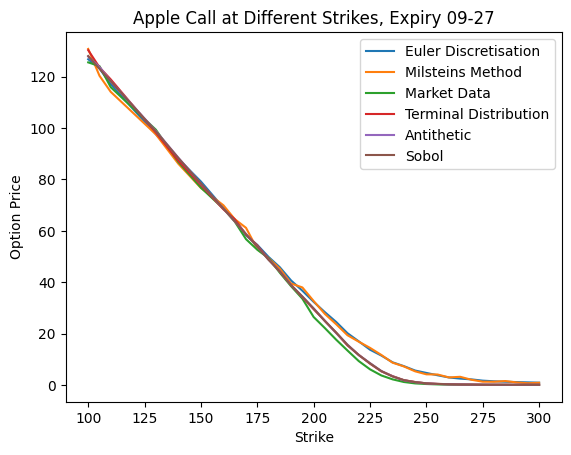

In [68]:
plt.plot(strikes, vals, label = "Euler Discretisation")
plt.plot(strikes, final_vals, label = "Milsteins Method")
plt.plot(strikes, calls["lastPrice"], label = "Market Data")
plt.plot(strikes, simulated_price, label = "Terminal Distribution")
plt.plot(strikes, simulated_price_anti, label = "Antithetic")
plt.plot(strikes, simulated_price_sobol, label = "Sobol")

plt.title("Apple Call at Different Strikes, Expiry 09-27")
plt.ylabel("Option Price")
plt.xlabel("Strike")
plt.legend()
plt.savefig("appleDiffModels.png")
plt.show()

#### Convergence plot of Euler and Milstein Discretisation

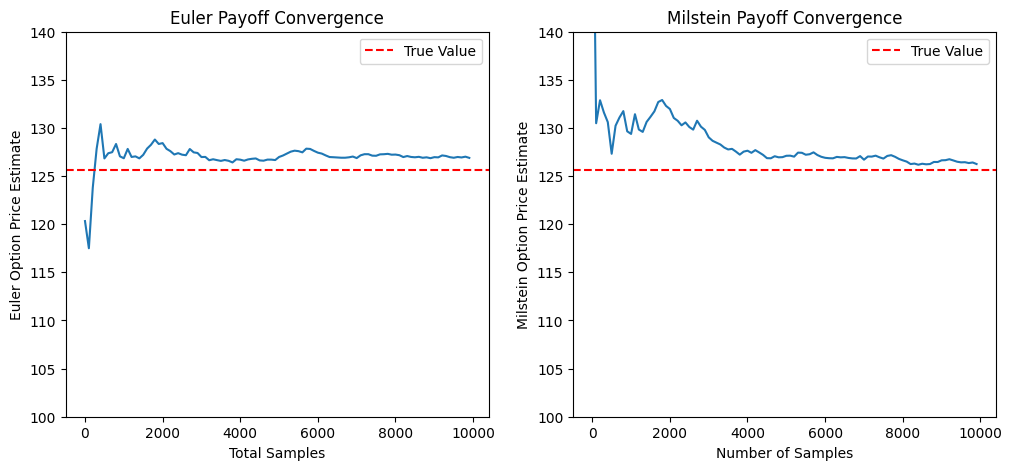

In [71]:
So = tk.info["currentPrice"]  
iv = calls.impliedVolatility[0]
Vo = iv
r = 0.21668014545292205         # Drift rate of the stock price
kappa = 3.7442       # Rate of mean reversion
theta = 0.24291637987256323       # Long-term varianc
sigma = 0.07835555563743023    # Volatility of variance
rho = -0.42075502643850055        # Correlation between stock price and variance
T = 18/256          # Time 
M = 500 #number of time steps
dt = T/M
N = 10000 #number of simulations

strikes = calls.strike[0]
K = strikes
true_price = calls['lastPrice'].iloc[0]

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

num_samps = np.arange(1, N+1, 100)
num_samps_m_payoff = np.empty(len(num_samps))
num_samps_e_payoff = np.empty(len(num_samps))

global_payoffs_e = []  # List to retain previously calculated Euler payoffs
global_payoffs_m = []  # List to retain previously calculated Milstein payoffs

for n in range(len(num_samps)):
    # Number of new samples to calculate in this iteration
    new_samples = num_samps[n] - len(global_payoffs_e)
    
    # Arrays to store new payoffs for this iteration
    payoffs_e = np.empty(new_samples)
    payoffs_m = np.empty(new_samples)
    
    for i in range(new_samples):
        S_e = np.insert(np.empty(M), 0, So)  # Euler arrays
        V_e = np.insert(np.empty(M), 0, Vo)
        
        S_m = np.insert(np.empty(M), 0, So)  # Milstein arrays
        V_m = np.insert(np.empty(M), 0, Vo)
        
        for j in range(M):
            xi1 = sc.norm.rvs()
            xi2 = sc.norm.rvs()
            S_m[j] = min(S_m[j], 10*So) #Cap asset growth
            
            # Euler scheme updates
            V_e[j+1] = V_e[j] + kappa*(theta-V_e[j])*dt + sigma*np.sqrt(max(V_e[j], 0)*dt)*xi1
            S_e[j+1] = S_e[j] + r*S_e[j]*dt + np.sqrt(max(V_e[j], 0)*dt)*S_e[j]*(rho*xi1 + np.sqrt(1-rho**2)*xi2)
    
            # Milstein scheme updates
            V_m[j+1] = V_m[j] + kappa*(theta-V_m[j])*dt + sigma*np.sqrt(max(V_m[j], 0)*dt)*xi1 + (0.25)*(sigma**2)*dt*(xi1**2-1)
            S_m[j+1] = S_m[j] + r*S_m[j]*dt + np.sqrt(max(V_m[j], 0)*dt)*S_m[j]*(rho*xi1 + np.sqrt(1-rho**2)*xi2) + (0.25)*(S_m[j]**2)*dt*((rho*xi1 + np.sqrt(1-rho**2)*xi2)**2 - 1)
    
            V_e[j+1] = max(V_e[j+1], 0)
            V_m[j+1] = max(V_m[j+1], 0)
    
        # Calculate payoffs
        payoffs_e[i] = np.exp(-r*T)*max(S_e[-1]-K, 0)
        payoffs_m[i] = np.exp(-r*T)*max(S_m[-1]-K, 0)
    
    # Append new payoffs to global lists
    global_payoffs_e.extend(payoffs_e)
    global_payoffs_m.extend(payoffs_m)
    
    # Calculate the mean payoff using all the payoffs so far
    num_samps_e_payoff[n] = np.mean(global_payoffs_e)     
    num_samps_m_payoff[n] = np.mean(global_payoffs_m)
ax1.plot(num_samps, num_samps_e_payoff)
ax2.plot(num_samps, num_samps_m_payoff)

ax1.set_xlabel('Total Samples')
ax1.set_ylabel('Euler Option Price Estimate')
ax1.set_title('Euler Payoff Convergence')
ax1.axhline(y=true_price, color='r', linestyle='--', label='True Value')


ax2.set_xlabel('Number of Samples')
ax2.set_ylabel('Milstein Option Price Estimate')
ax2.set_title('Milstein Payoff Convergence')
ax2.axhline(y=true_price, color='r', linestyle='--', label='True Value')

ax1.legend()
ax2.legend()
ax1.set_ylim([100, 140])
ax2.set_ylim([100, 140])
plt.show()